# 0. START

## 0.0. LIBRARY DOWNLOAD

In [ ]:
pip install inflection seaborn matplotlib IPython jupyter_contrib_nbextensions scipy sklearn  tabulate  random warnings flask  requests os

  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)
ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install inflection sklearn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install boruta

Note: you may need to restart the kernel to use updated packages.


## 0.1. IMPORTS

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [ ]:
import math #identificar num
import numpy  as np
import pandas as pd
import inflection #muda formato das palavras
import datetime as datetime

import seaborn as sns #visualisation

from matplotlib import pyplot as plt
from IPython.core.display import HTML #expande celula python
from IPython.display import Image #adciona magem

from scipy import stats as ss #biblioteca estatistica qu aplica coisa omo probability distribuitions, depende numpy

from sklearn.preprocessing import RobustScaler #RobustScaler:descosidera outliers. MinMaxscaler
from sklearn.preprocessing import MinMaxScaler #scales the minimum and maximum values to be 0 and 1 respectivel, nao desconsidera outiers
from sklearn.preprocessing import LabelEncoder #em variaveis categoricas substitui as palavras por numeros que passarama identificalo

from boruta import BorutaPy # duplica o conjunto de dados criando variáveis sombras e mistura-se aleatoriamente os valores verificando para cada variável real se a mesma tem um importancia maior que a variável
from sklearn.ensemble import RandomForestRegressor #permite implemengtar random forest

from sklearn.metrics import mean_absolute_error #Calucula o MAE, 
from sklearn.metrics import mean_squared_error #Calcula o MSE,
from sklearn.linear_model import LinearRegression #implementa rgressao linear. Boa para valores constantes
from sklearn.linear_model import Lasso #reduz o coefciente e variaveis nao importantes 
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb #aprendizado de maquina baseado em arvore de decisao

import random
import warnings

import pickle #serealiza objetos para armazenamento
from flask import Flask, request, Response #construcao API
import json
import requests #envia solicitacoes HTTP durante o API
import os #permite acessar funcionldiades sistema operacional

## 0.2. HELPER FUNCTIONS

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    #define tasmanho celulas
    
def cramer_v(x,y): # Mede o grau de correlacao entre as variaveis. Sempre e[ positiva]
        cm = pd.crosstab(x,y).values #crosstab avalia como 22 variaveis se relaciona contando por exp a frequencia de relacao
        n = cm.sum()
        r, k = cm.shape
        
        chi2 = ss.chi2_contingency( cm )[0]
        chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1)) #evitsa qure o modelo substime 
        
        kcorr = k-(k-1)**2/(n-1)
        rcorr = r-(r-1)**2/(n-1)
        
        return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))
    
    
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y)) #ABS considera APENAS VALORESABSOULUTOS, ISTO É, PPOSITIVOS


def m1_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat)) # Eleva o Mae ao quadrado. Util para saber o impacto dos outliers. tecnico, mede performance ML
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])


def cross_validation(x_training, kfold, model_name, model, verbose=False):
        mae_list = []
        mape_list = []
        rmse_list = []
        for k in reversed( range( 1, kfold+1 ) ): #kfold = subconjunto que sera dividido
            if verbose:
                print( '\nKFold Number: {}'.format( k ) )
            #start and end date for validation
            validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
            validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

            #filtering dataset
            training = x_training[x_training['date'] < validation_start_date]
            validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

            # training and validation dataset
            xtraining = training.drop(['date', 'sales'], axis=1)
            ytraining = training['sales']

            #validation
            xvalidation = validation.drop(['date', 'sales'], axis=1)
            yvalidation = validation['sales']

            # model 
            m = model.fit(xtraining, ytraining)

            #prediction
            yhat = m.predict( xvalidation )

            #perfomance
            m_result = m1_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ))

            #store performance pofd each kfold iunteration
            mae_list.append(m_result['MAE'])
            mape_list.append(m_result['MAPE'])
            rmse_list.append(m_result['RMSE'])

            #mean and str
        return pd.DataFrame( {'Model Name': model_name,
                              'MAE cv': np.round( np.mean( mae_list),2 ).astype( str ) + '+/-' + np.round( np.std( mae_list),2 ).astype(str),
                              'MAPE cv': np.round( np.mean( mape_list ),2).astype( str ) + '+/-' + np.round( np.std( mape_list ),2 ).astype(str),
                              'RMSE cv': np.round( np.mean( rmse_list ),2).astype( str ) + '+/-' + np.round( np.std( rmse_list ),2 ).astype(str)}, 
                           index=[0] )
        #analza a produtividade do algoritmo de predçao

In [ ]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/arquinho/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.3. Loading data

In [ ]:
df_sales_raw = pd.read_csv( '/home/arquinho/REPOS/ds-producao/DsProducao/data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( '/home/arquinho/REPOS/ds-producao/DsProducao/data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

dff = df_store_raw

#  # CompetitionDistance
# dff = dff[~dff['CompetitionDistance'].isnull()]
# dff['CompetitionDistance'] = dff['CompetitionDistance'].astype(int64)


#         # CompetitionOpenSinceMonth
# dff = dff[~dff['CompetitionOpenSinceMonth'].isnull()]
# dff['CompetitionOpenSinceMonth'] = dff['CompetitionOpenSinceMonth'].astype(int64)


#         # CompetitionOpenSinceYear
# dff = dff[~dff['CompetitionOpenSinceYear'].isnull()]
# dff['CompetitionOpenSinceYear'] = dff['CompetitionOpenSinceYear'].astype(int64)

#         # Promo2SinceWeek
# dff = dff[~dff['Promo2SinceWeek'].isnull()]
# dff['Promo2SinceWeek'] = dff['Promo2SinceWeek'].astype(int64)

#         # Promo2SinceYear
    
# dff = dff[~dff['Promo2SinceYear'].isnull()]
# dff['Promo2SinceYear'] = dff['Promo2SinceYear'].astype(int64)

#         # Promo2
# dff = dff[~dff['Promo2'].isnull()]
# dff['Promo2'] = dff['Promo2'].astype(int64)


In [ ]:
dff.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

# 1.0. DATA DESCRIPTION

In [ ]:
df1 = df_raw.copy()

### 1.1. Rename Columns

In [ ]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [ ]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [ ]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [ ]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [ ]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
836623,44,2,2013-06-11,4238,576,1,0,0,0,a,a,540.0,6.0,2011.0,0,NaN,NaN,NaN


In [ ]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# x['date'].week/year/month selecionam apenas o especifico
#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )
#dt. month attribute return a numpy array containing the month of the datetime in the underlying data of the given series object

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 ) #split especifica o separados


In [ ]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

In [ ]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistics

In [ ]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] ) #todas as variaveis numericas
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] ) #eclui todas as variaves numericas e data

### 1.7.1. Numerical Atributes

In [ ]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T # mede a assimitria dis dasdos. Para a direita positiva e esquerda negativa
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T # mede a distribuiçao dos dados. calda curta (leptocurtica) mais fechada que a 
#distribuiçao normal. Calda longa (platicurtica) mais aberta que a distribuiçao bnormal. Quanto mais proxima de 0 o aor mais Normal é

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/home/arquinho/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance'>

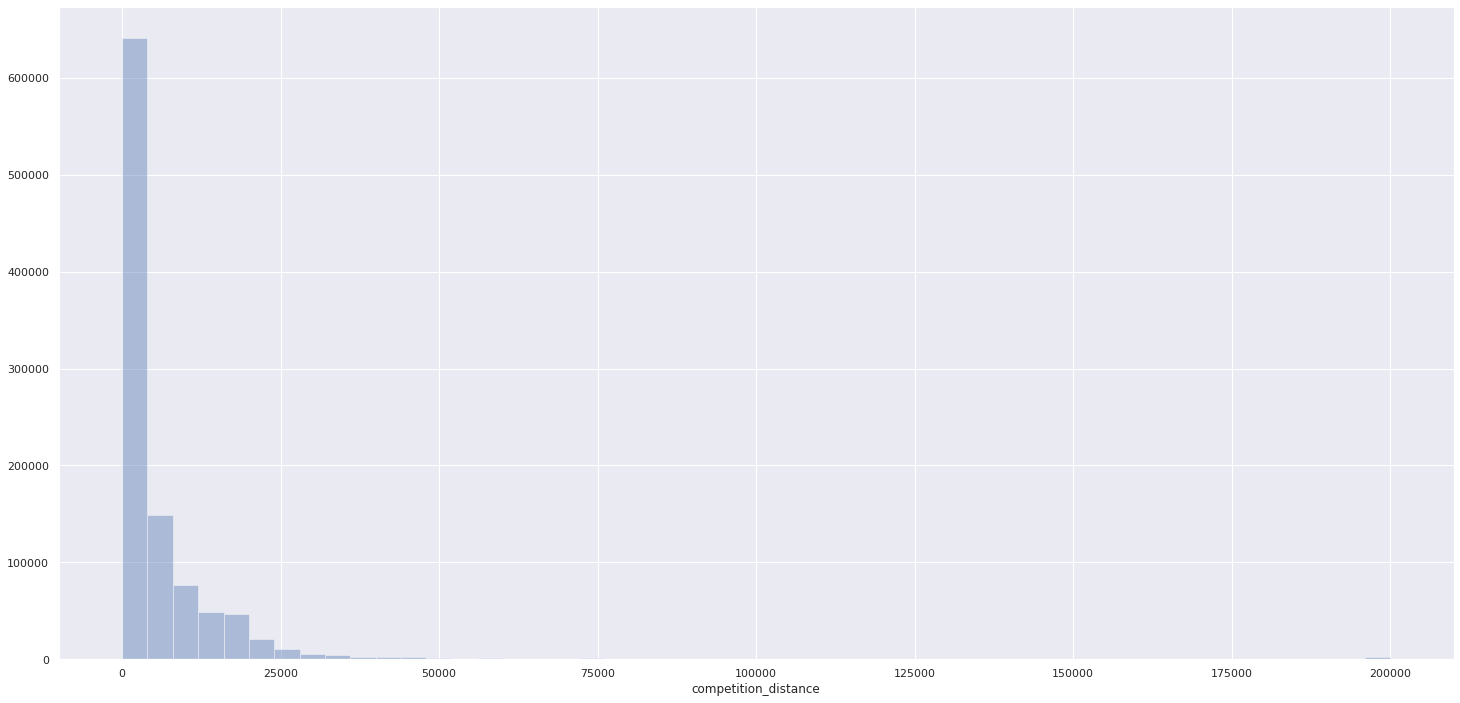

In [ ]:
sns.distplot( df1['competition_distance'], kde=False )

### 1.7.2. Categorical Atributes

In [ ]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

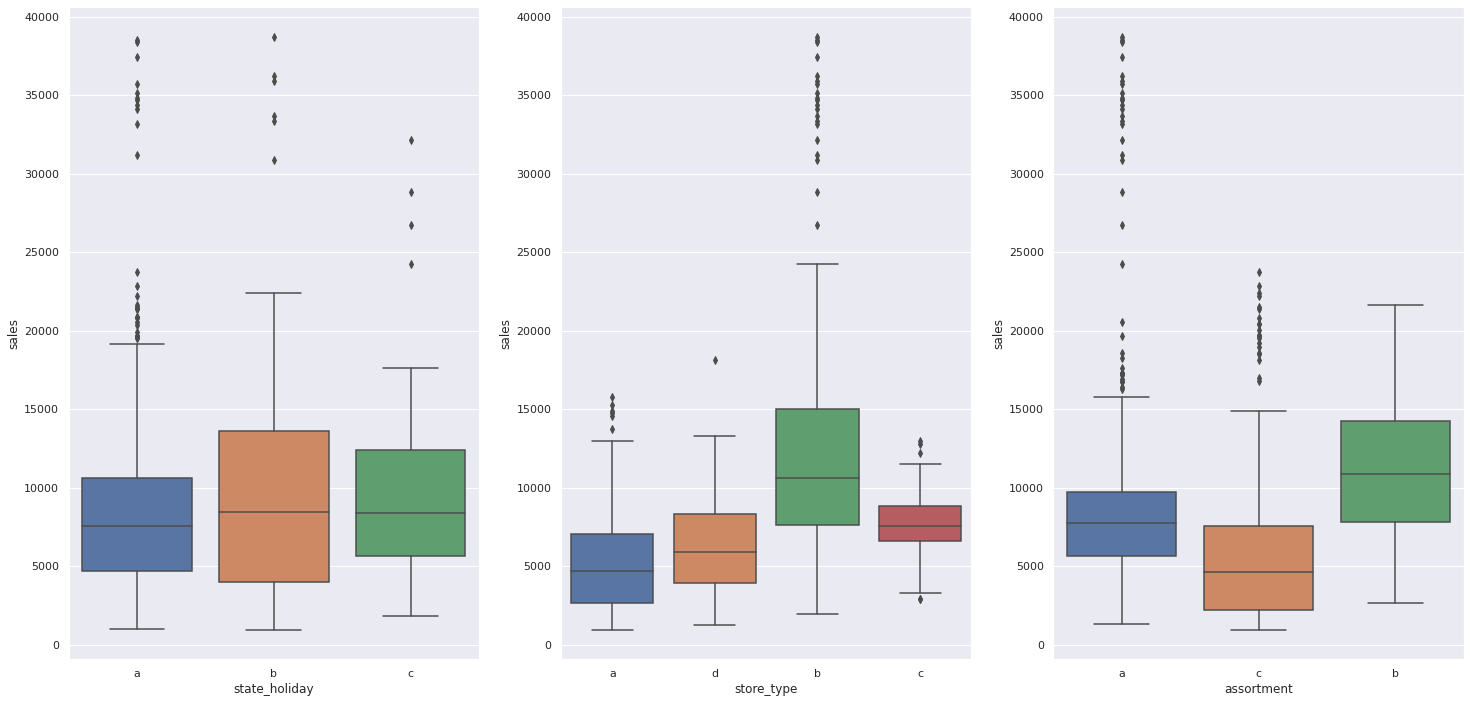

In [ ]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0.  FEATURE ENGINEERING

In [ ]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

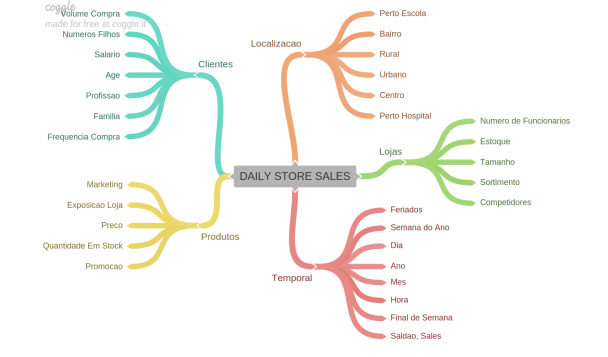

In [ ]:
Image( '/home/arquinho/REPOS/ds-producao/DsProducao/img/Hypothesis.png' )

## 2.2. Criacao das Hipoteses

### 2.2.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4. Feature Engineering

In [ ]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week 

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

# 3.0.  FILTERING OF VARIABLES

In [ ]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas


In [ ]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das Colunas

In [ ]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [ ]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270.0,570.0,14130.0,620.0,29910.0


# 4.0.  DATA EXPLORATORY ANALYSIS

In [ ]:
df4 = df3.copy()

### 4.1. Analise Univariada

## 4.1.1. Response Variable

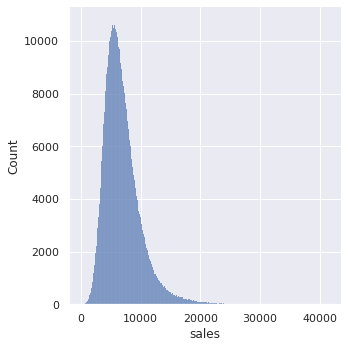

In [ ]:
sns.displot(df4['sales'], kde=False)

## 4.1.1. Numerical Variable

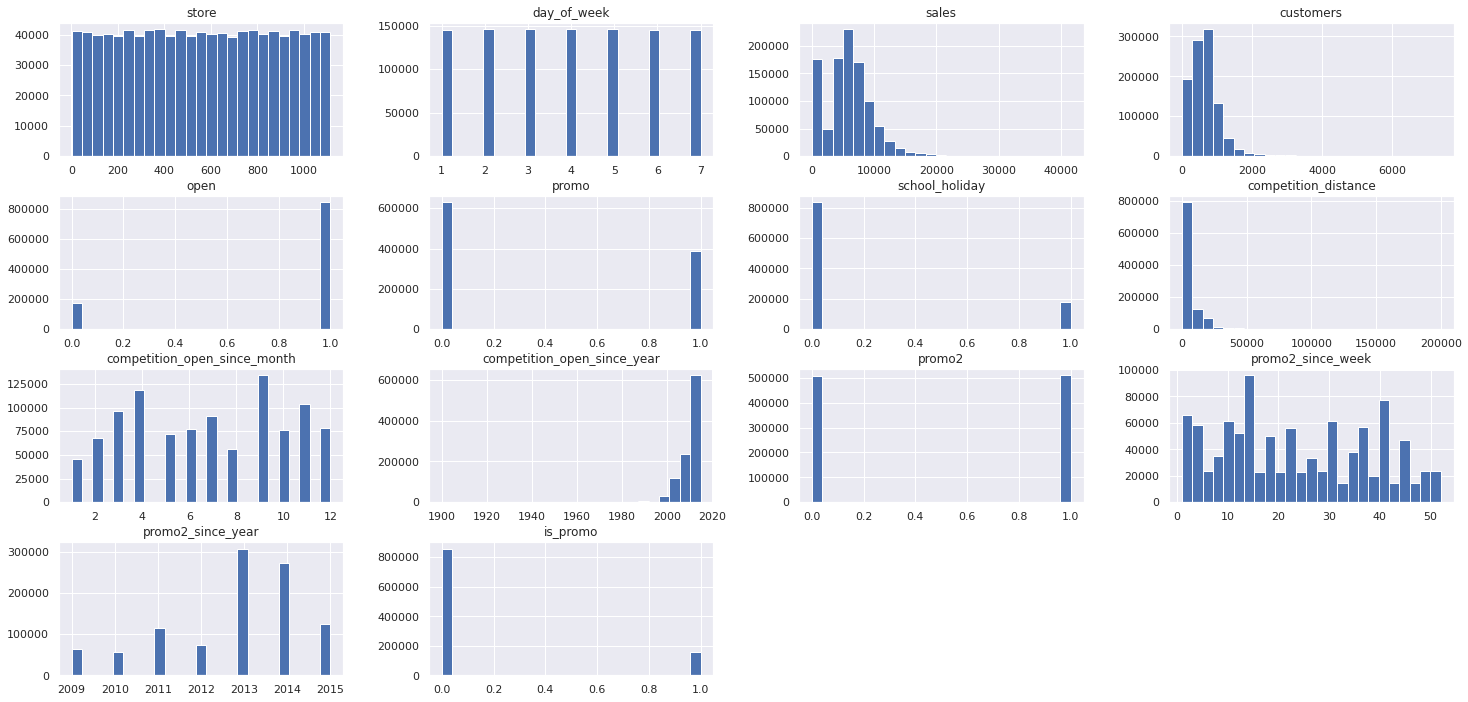

In [ ]:
num_attributes.hist(bins=25)

## 4.1.1. Categorical Variable

/home/arquinho/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/arquinho/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/arquinho/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

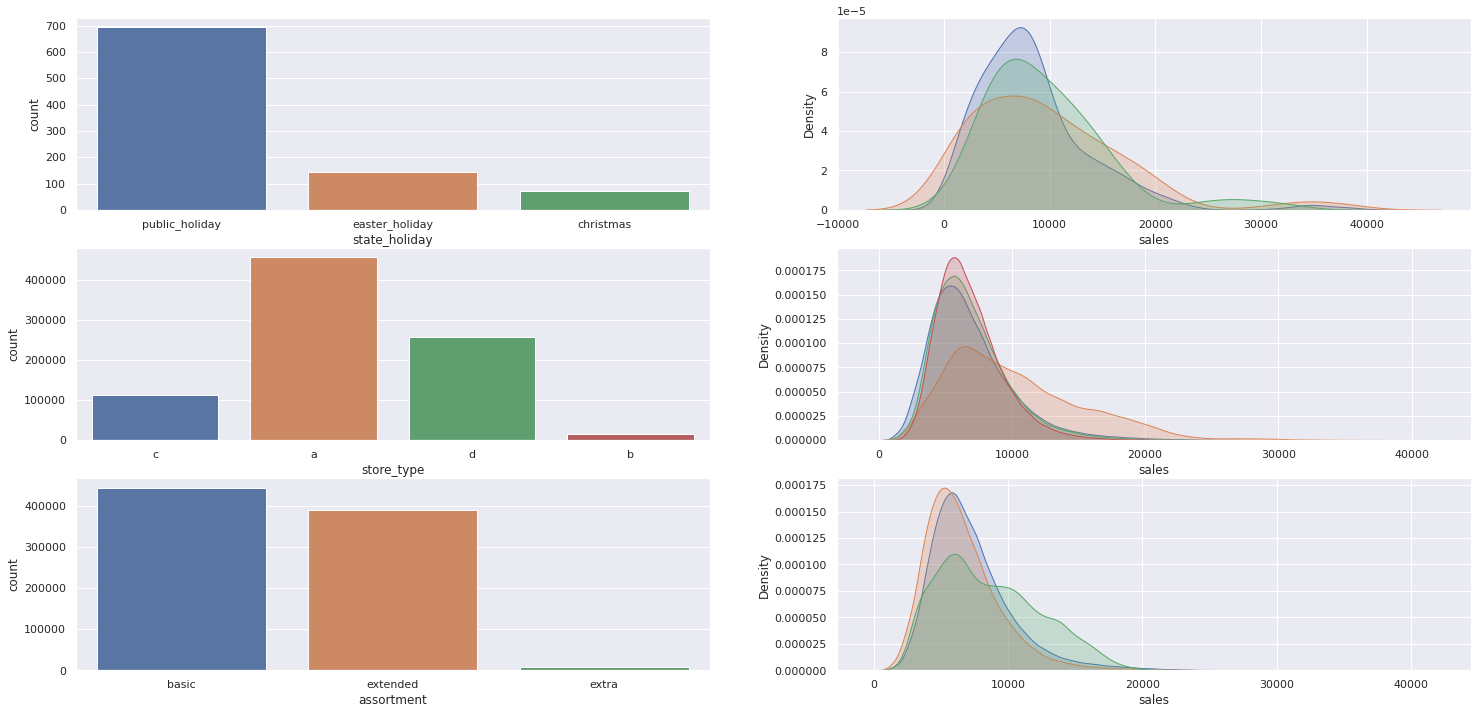

In [ ]:
#state_holiday

plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],
            label='public_holiday',
            shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],
            label='easter_holiday',
            shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],
            label='christmas',
            shade=True)

#store type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],
            label='extended',
            shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],
            label='basic',
            shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],
            label='extra',
            shade=True)

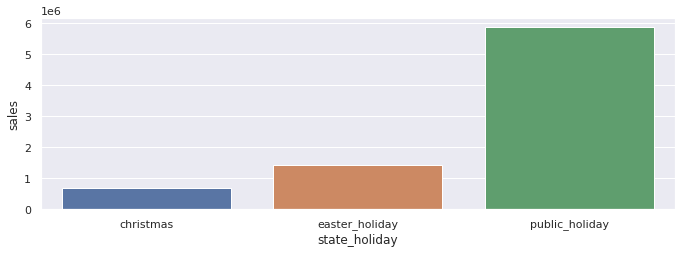

In [ ]:
#state_holiday

plt.subplot(3, 2, 1)
aux1 = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux1[['state_holiday',
             'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

## 4.2. Analise Bivariada

**1.** Lojas com maior sortimentos deveriam vender mais.

**VERDADEIRO** Lojas com MAIOR SORTIMENTO vendem MAIS

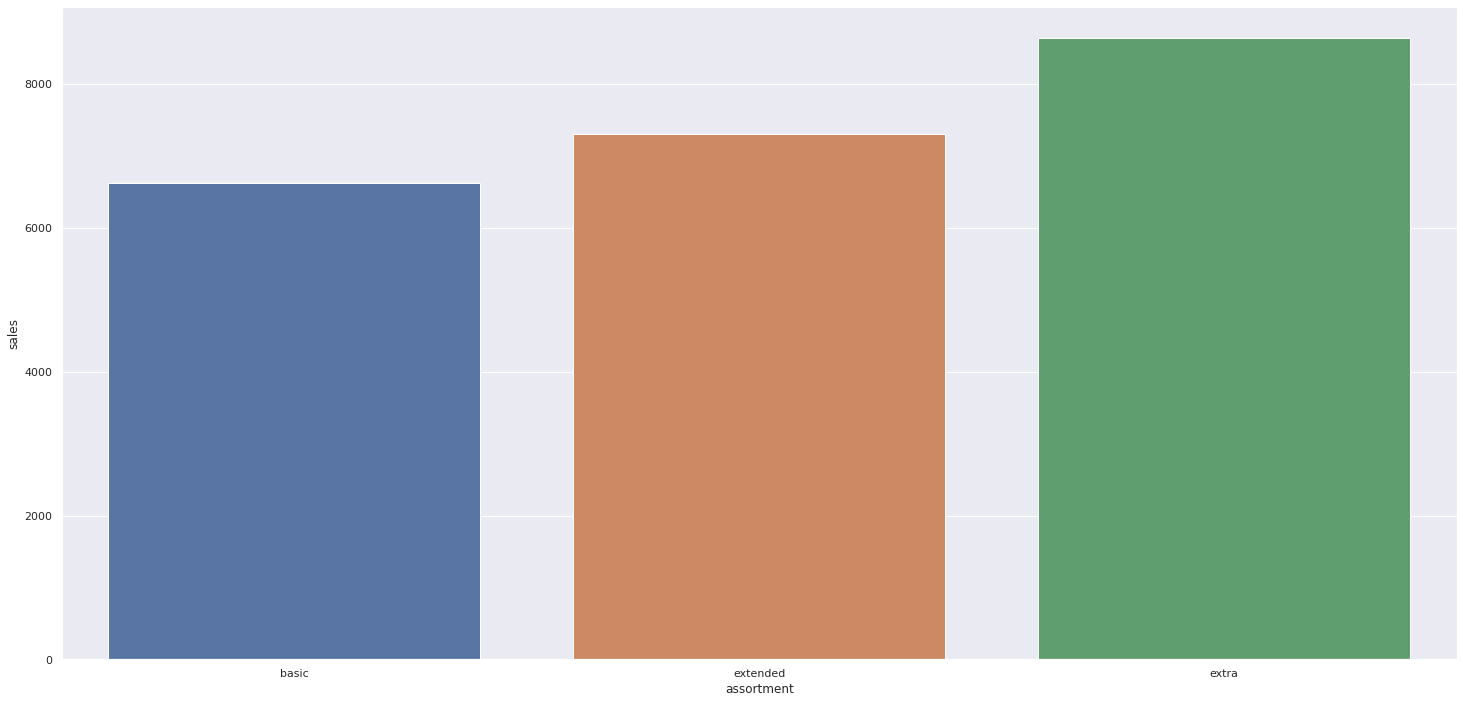

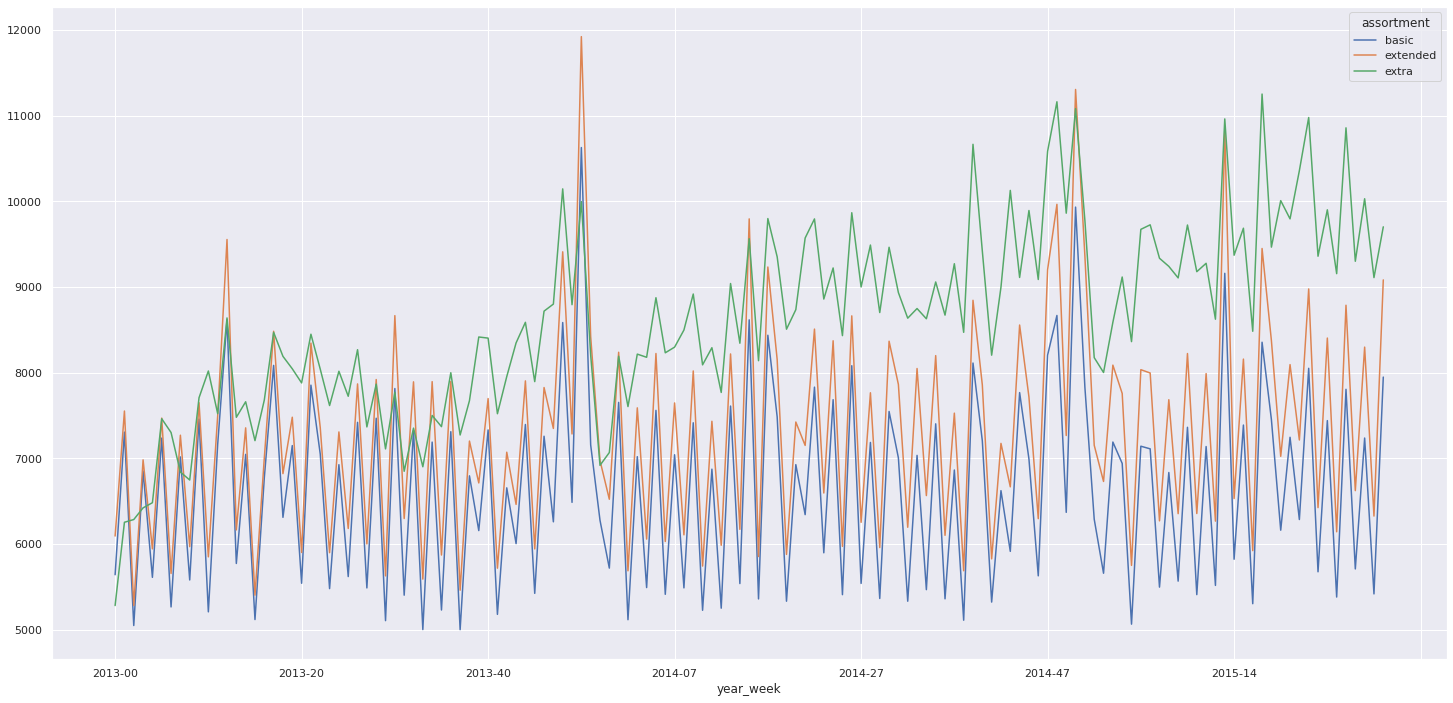

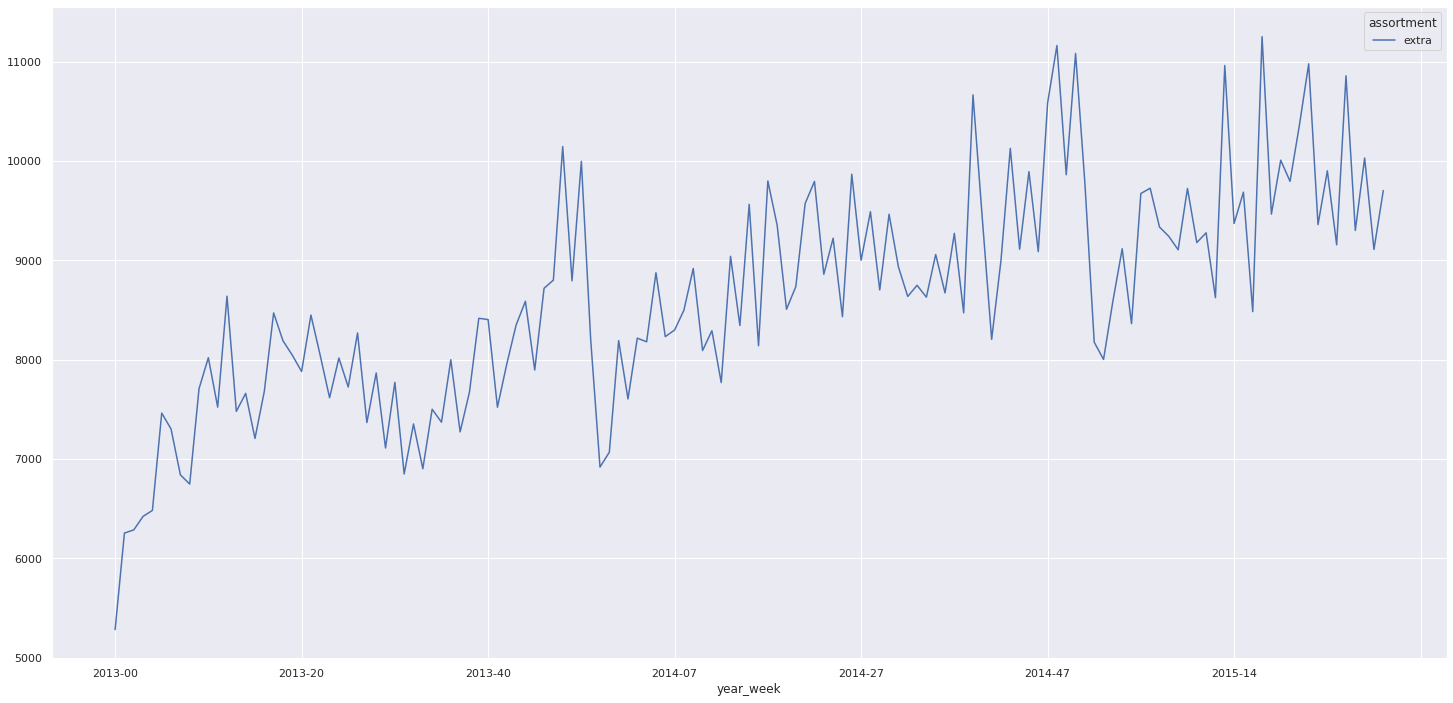

In [ ]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment',
            'sales']].groupby(['year_week',
                               'assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

**2.** Lojas com competidores mais próximos deveriam vender menos.

**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS

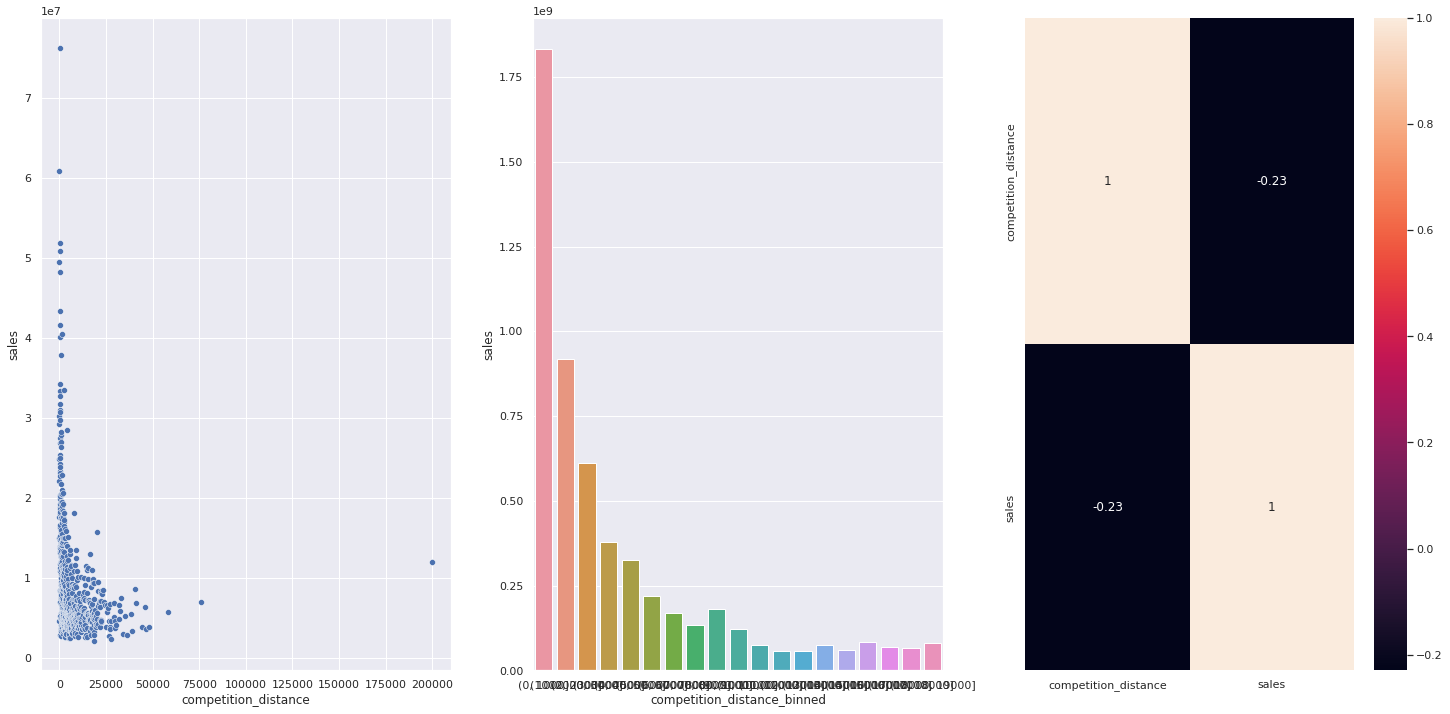

In [ ]:
aux1 = df4[['competition_distance',
            'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],
                                             bins=bins)

aux2 = aux1[['competition_distance_binned', 'sales'
             ]].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x='competition_distance_binned', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**FALSA** Lojas com COMPETIDORES A MAIS TEMPO vendem MENOS 

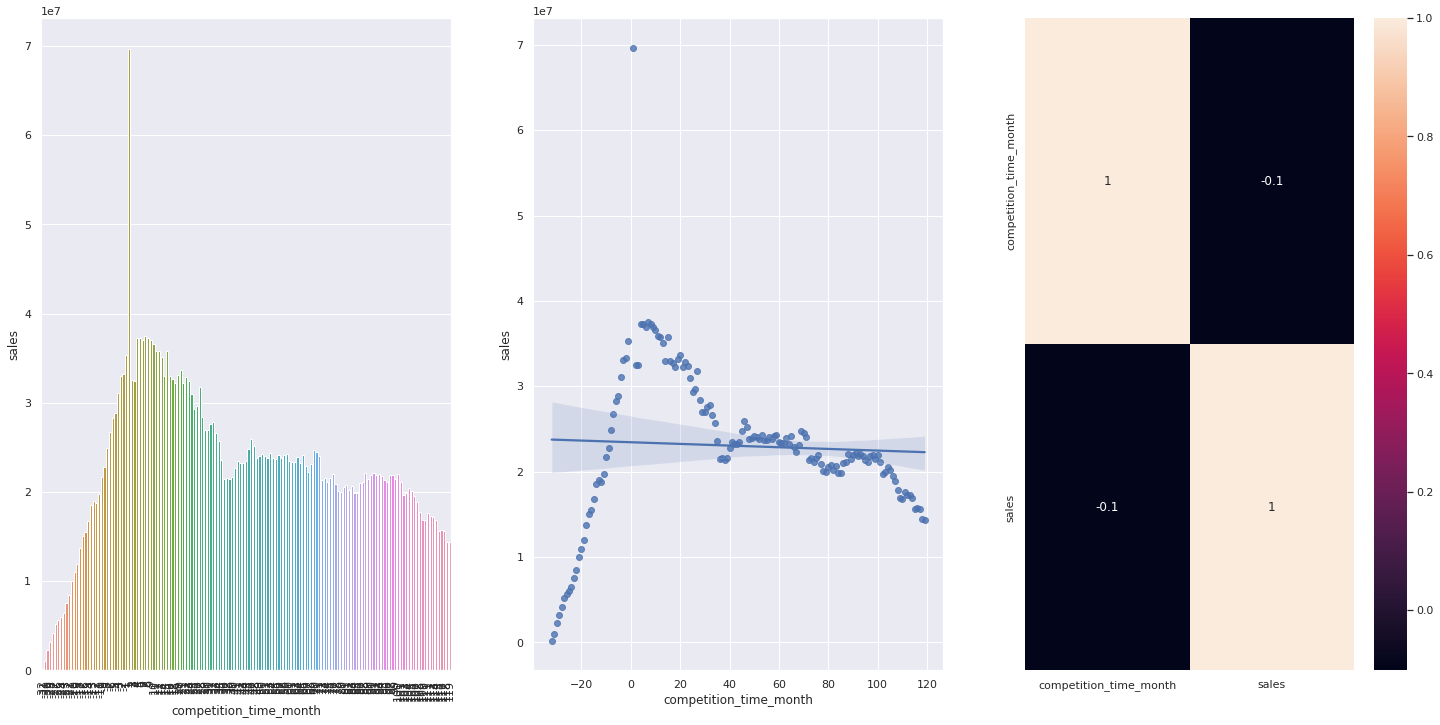

In [ ]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month',
            'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120)
            & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**FALSA** Lojas com promocoes ATIVAS por MAIS TMEPO vendem MENOS depois de certo periodo de tempo

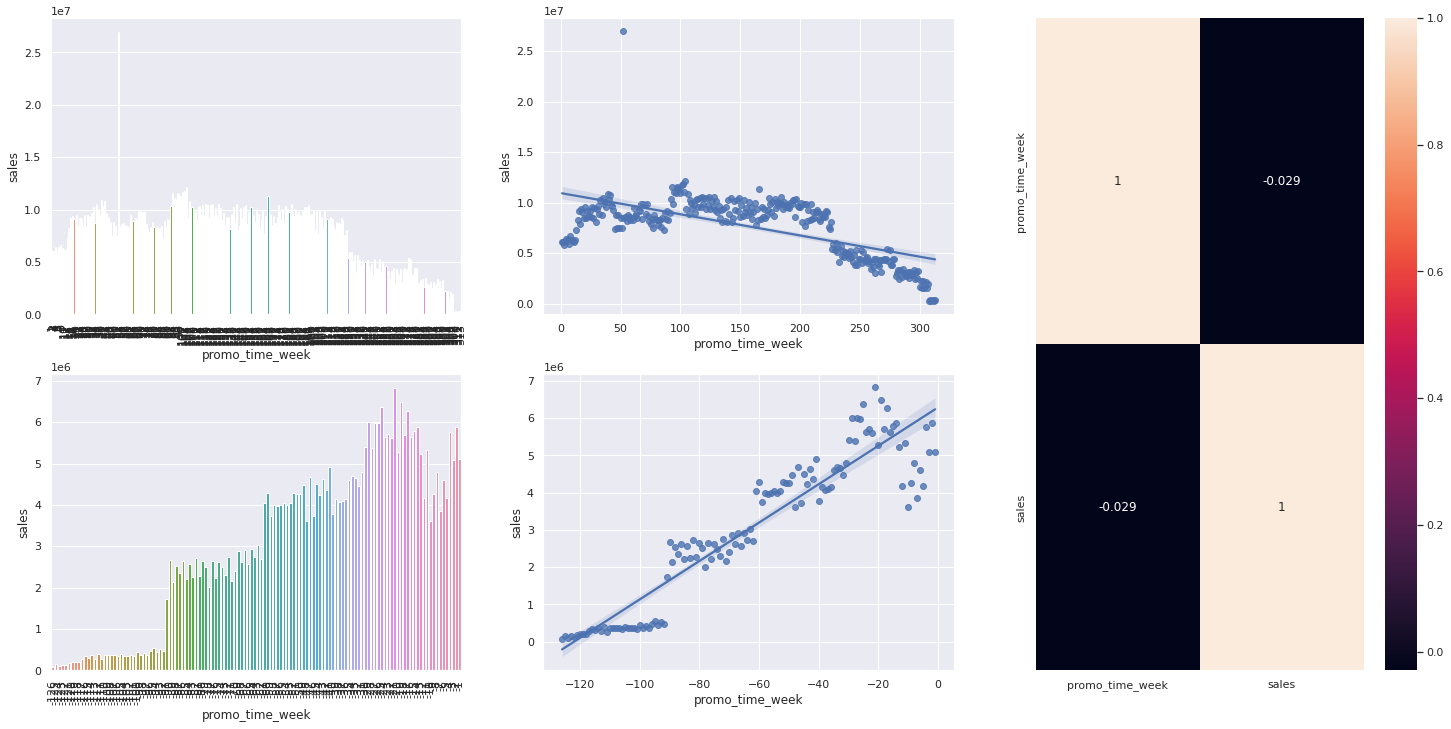

In [ ]:
aux1 = df4[['promo_time_week',
            'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0]  #promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)

plt.subplot(grid[1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0]  #regular promo
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90)

plt.subplot(grid[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)


**5.** <s>Lojas com mais dias de promoção deveriam vender mais.<s/>




**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**FALSA** Lojas com MAIS promocoes CONSECUTIVAS vendem menos

In [ ]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


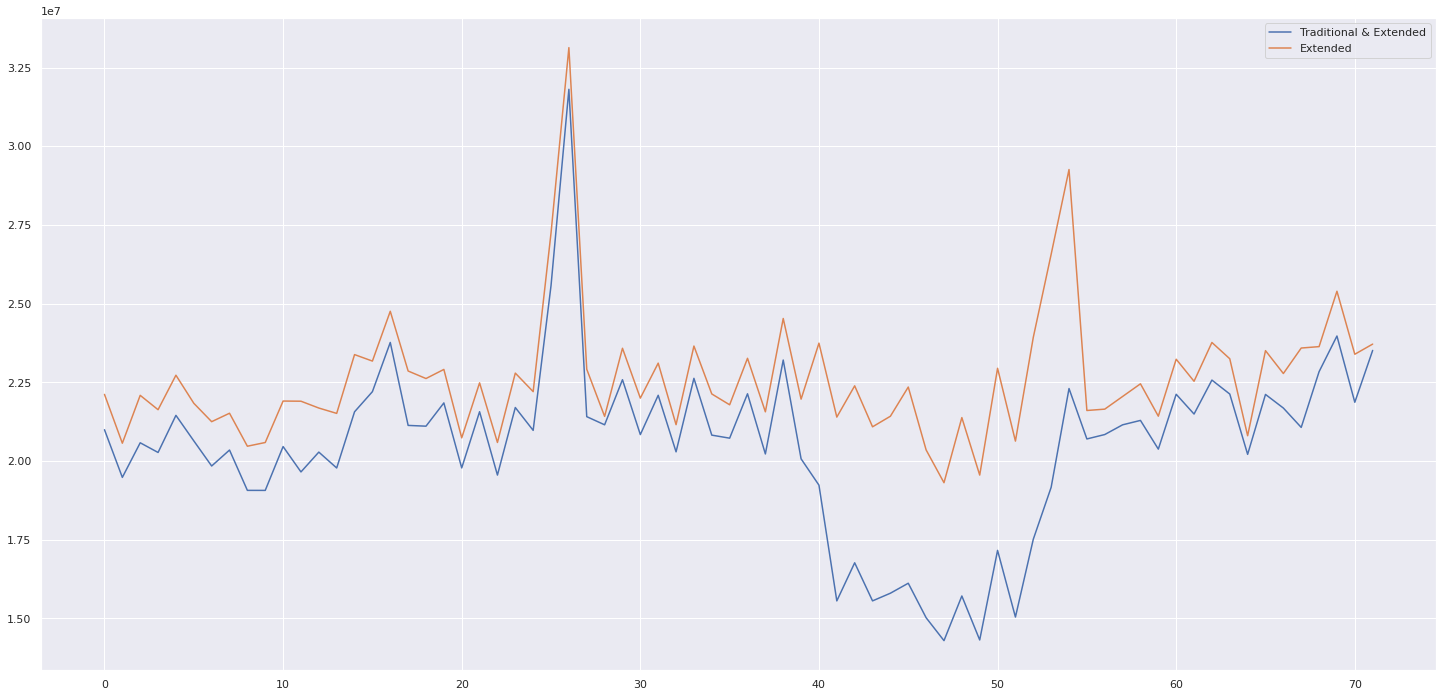

In [ ]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][[
    'year_week', 'sales'
]].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][[
    'year_week', 'sales'
]].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Traditional & Extended', 'Extended'])

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**FALSA** Lojas ABERTAS durante o NATAL vendem MENOS

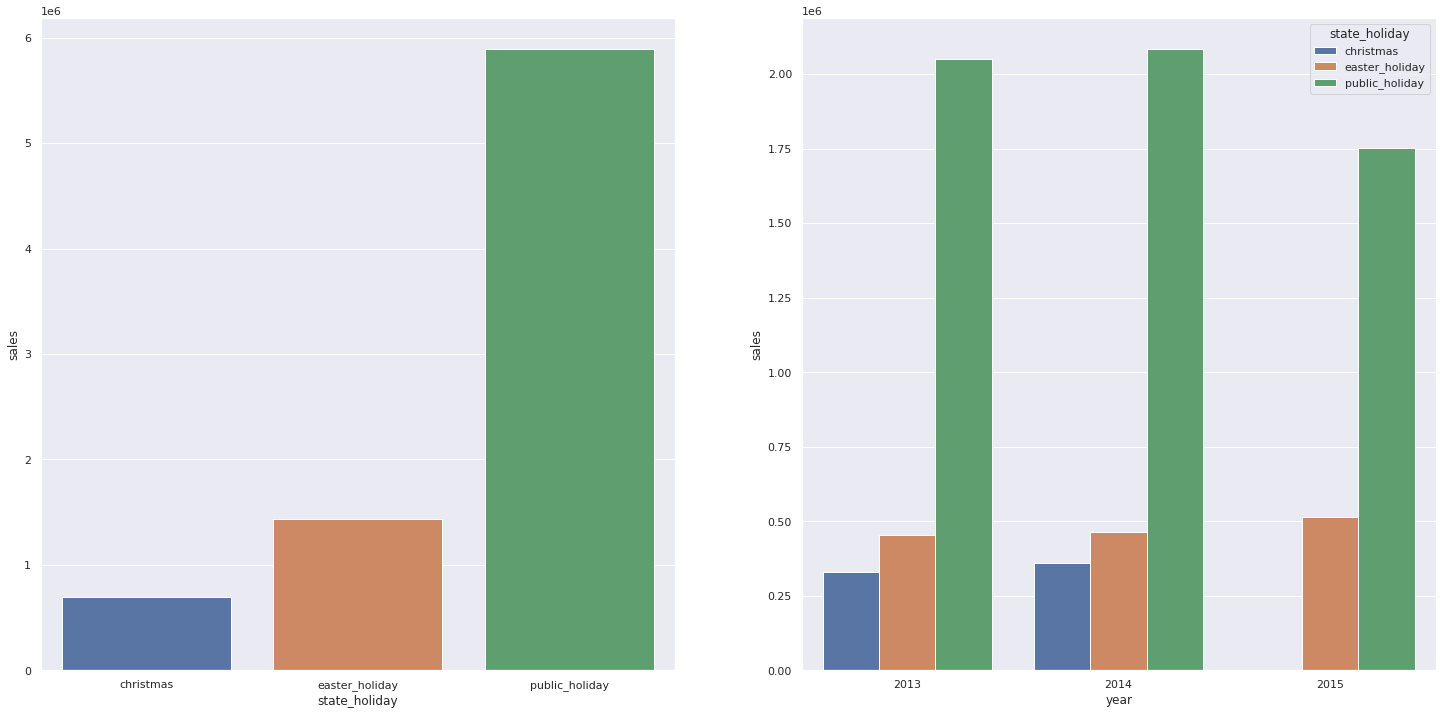

In [ ]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday',
            'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday',
            'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)


**9.** Lojas deveriam vender mais ao longo dos anos.

**FALSO** O fluxo de vendas anuais estao em constante caimento


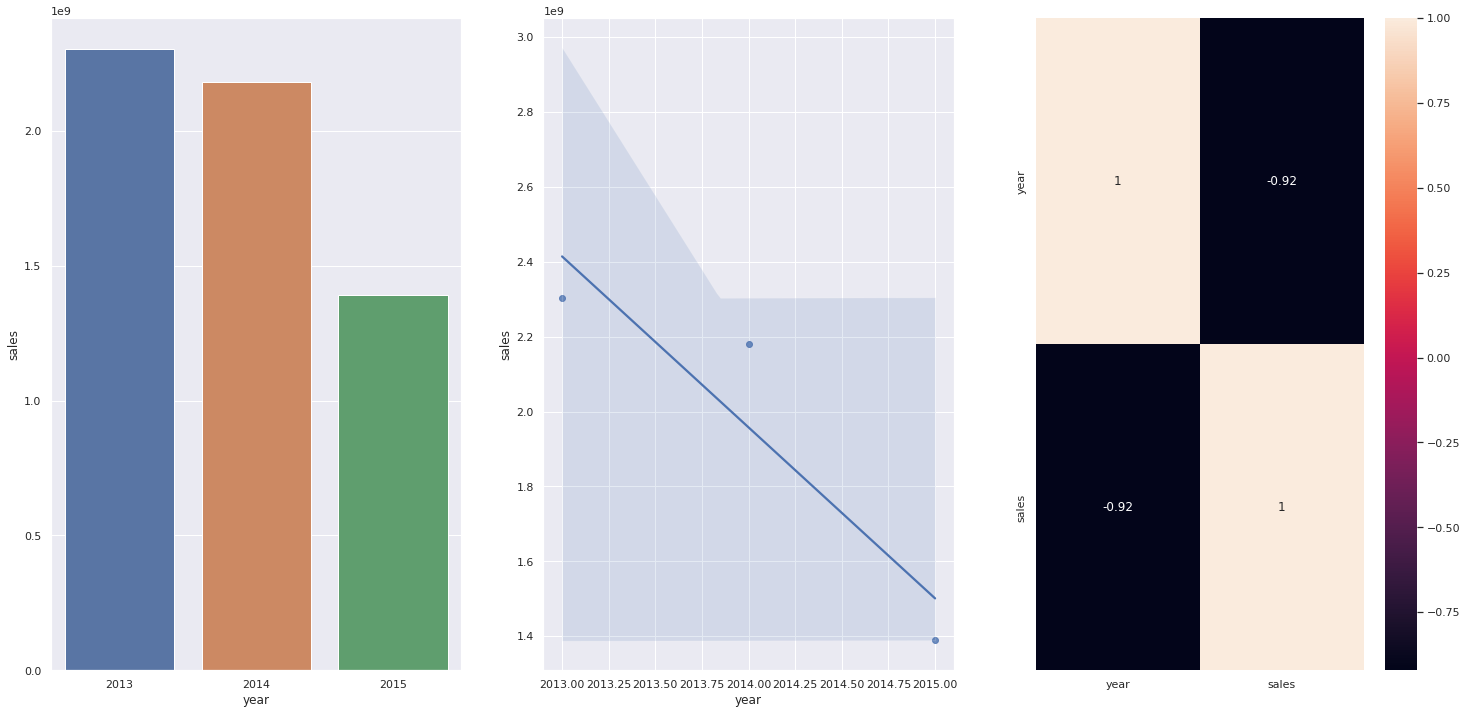

In [ ]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)



**10.** Lojas deveriam vender mais no segundo semestre do ano.

**FALSO** As lojas vendem MENOS no segundo semestre

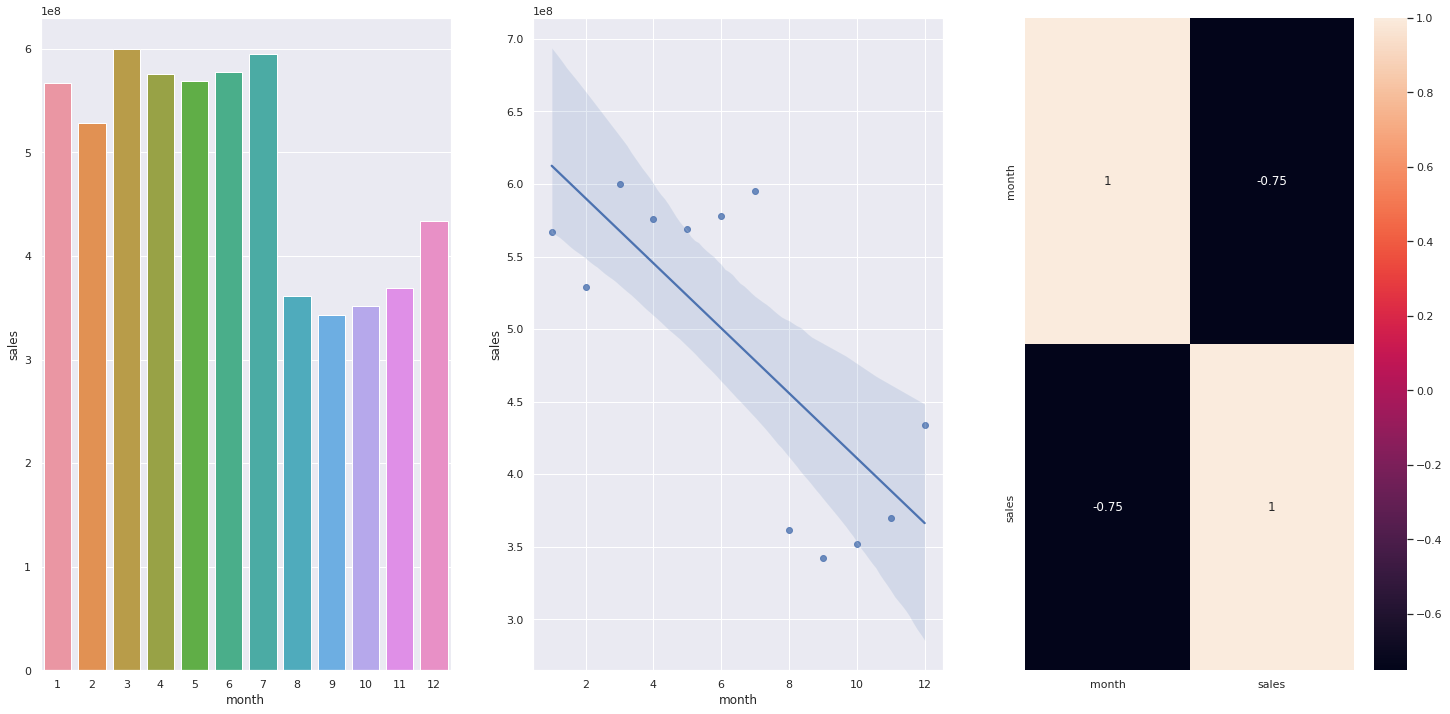

In [ ]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)



**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**VERDADEIRO** O maior numero de vendas se concetra APOS O DIA 10

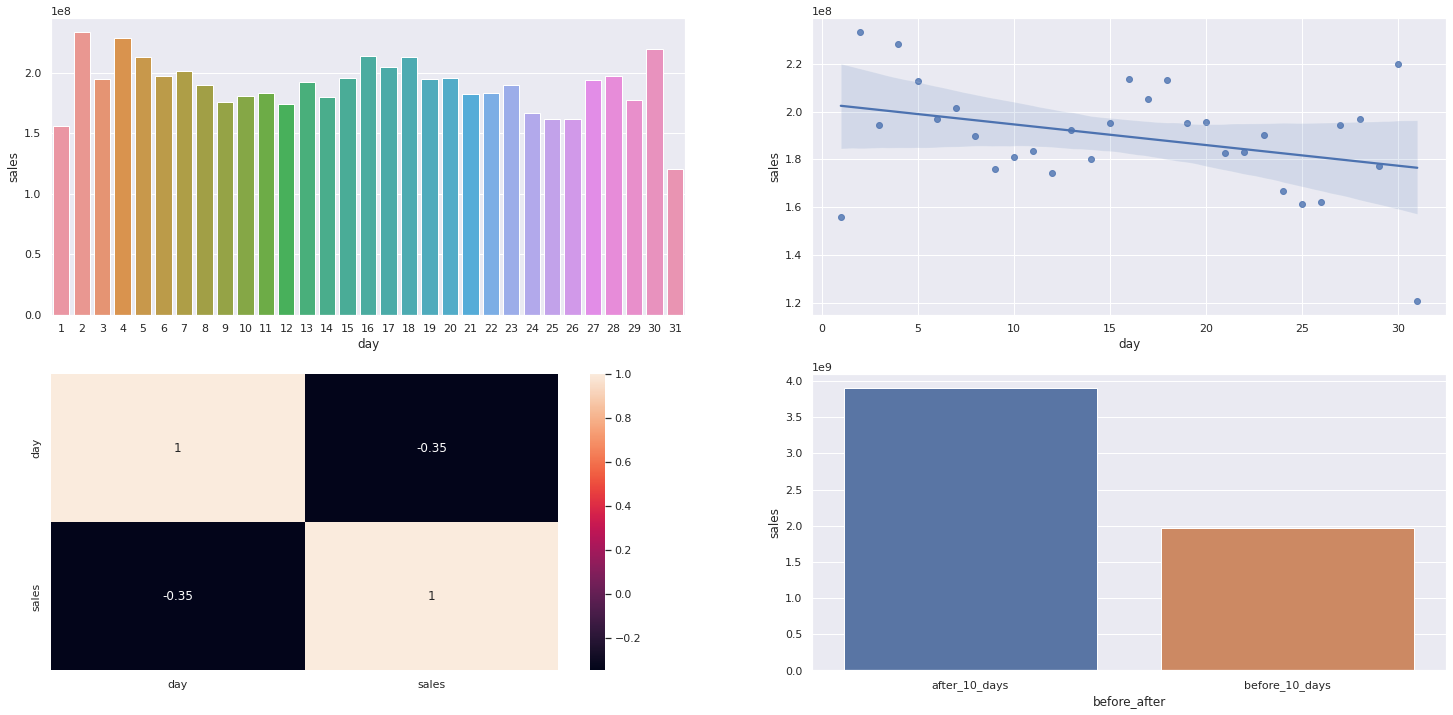

In [ ]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days'
                                         if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after',
             'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2)



**12.** Lojas deveriam vender menos aos finais de semana.

**VERDADEIRO**, os MENORES numeros de venda da semana se concentram aos FINAIS de SEMANA

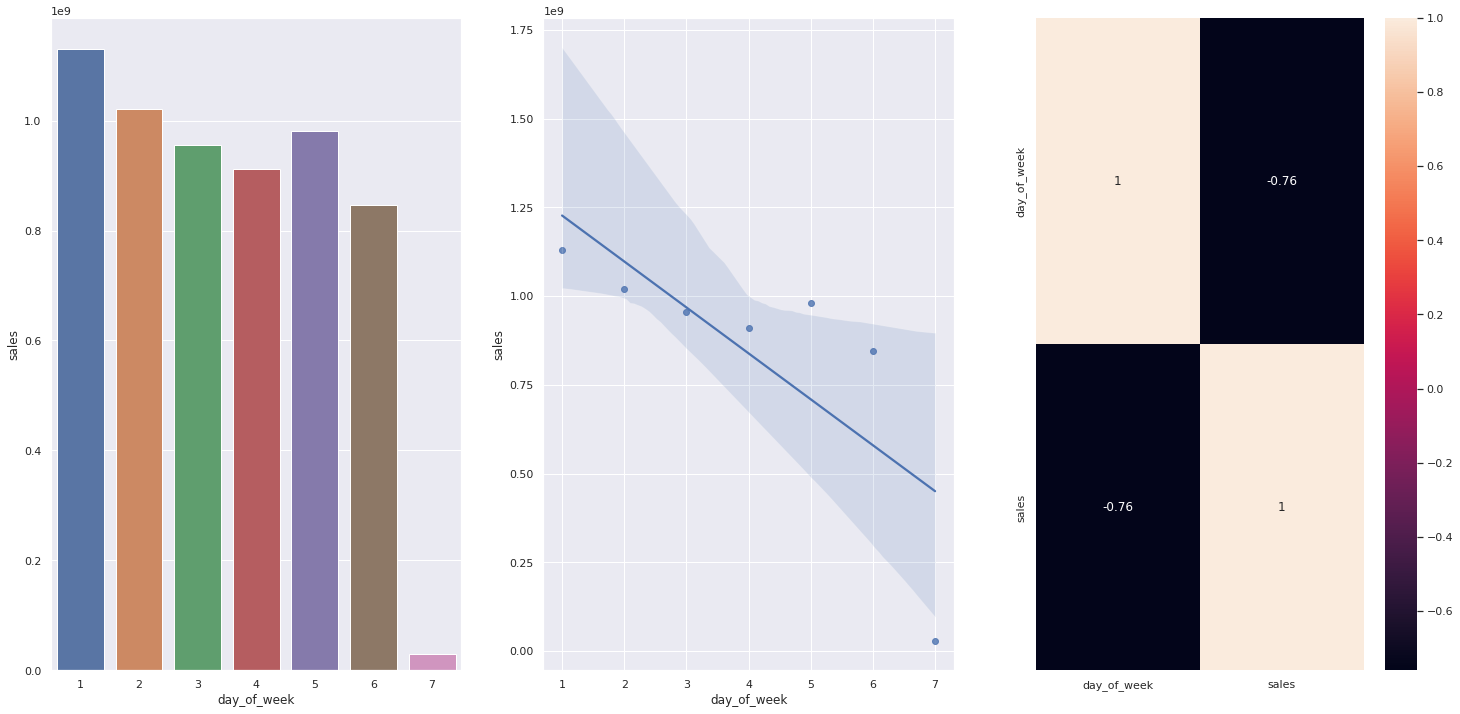

In [ ]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)


**13.** Lojas deveriam vender menos durante os feriados escolares.

**VERDADEIRO** Vendme menos exceto No mes de Julho se EQUIPARA e em Agosto se VENDE MAIS

In [ ]:
#from tabulate import tabulate

## 4.3. Analise Muiltivariada

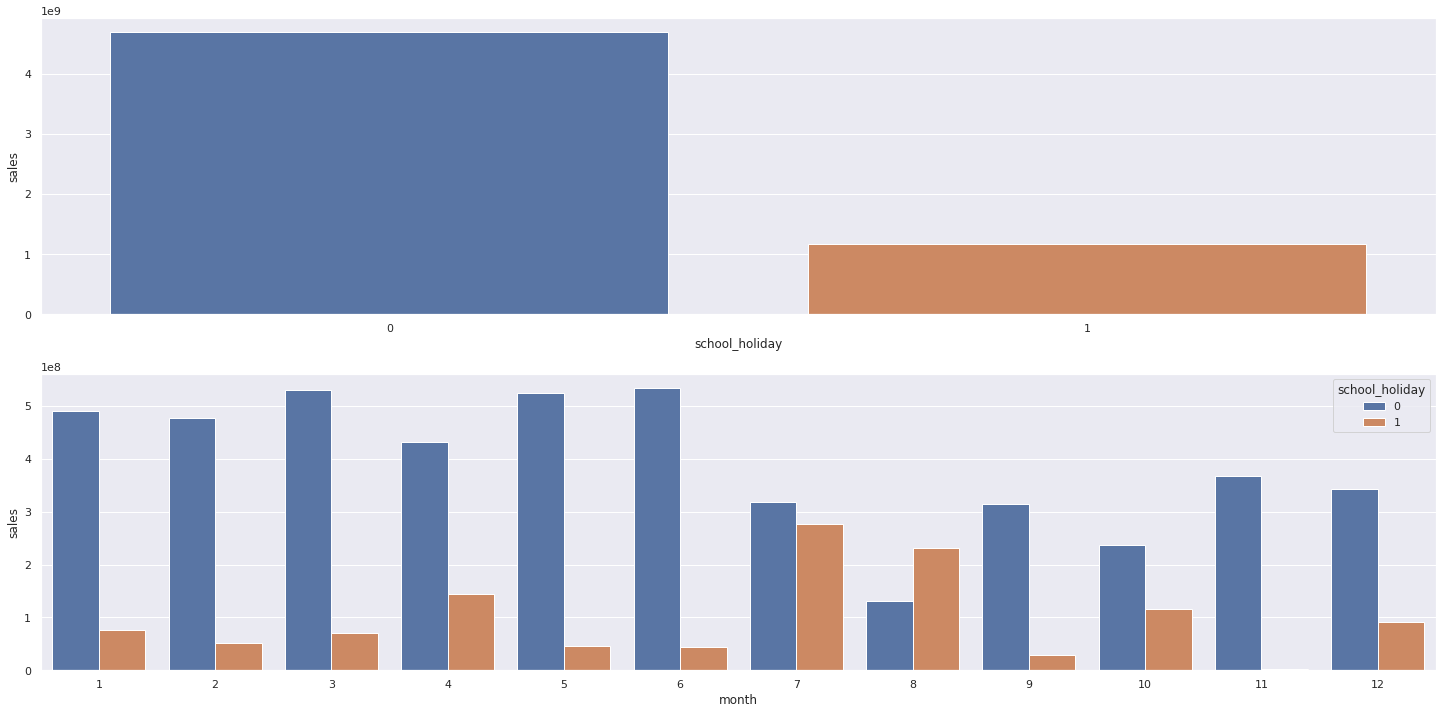

In [ ]:
aux1 = df4[['school_holiday',
            'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

aux2 = df4[['month', 'school_holiday',
            'sales']].groupby(['month', 'school_holiday']).sum().reset_index()

plt.subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)

### 4.3.1 Numerical Attributes

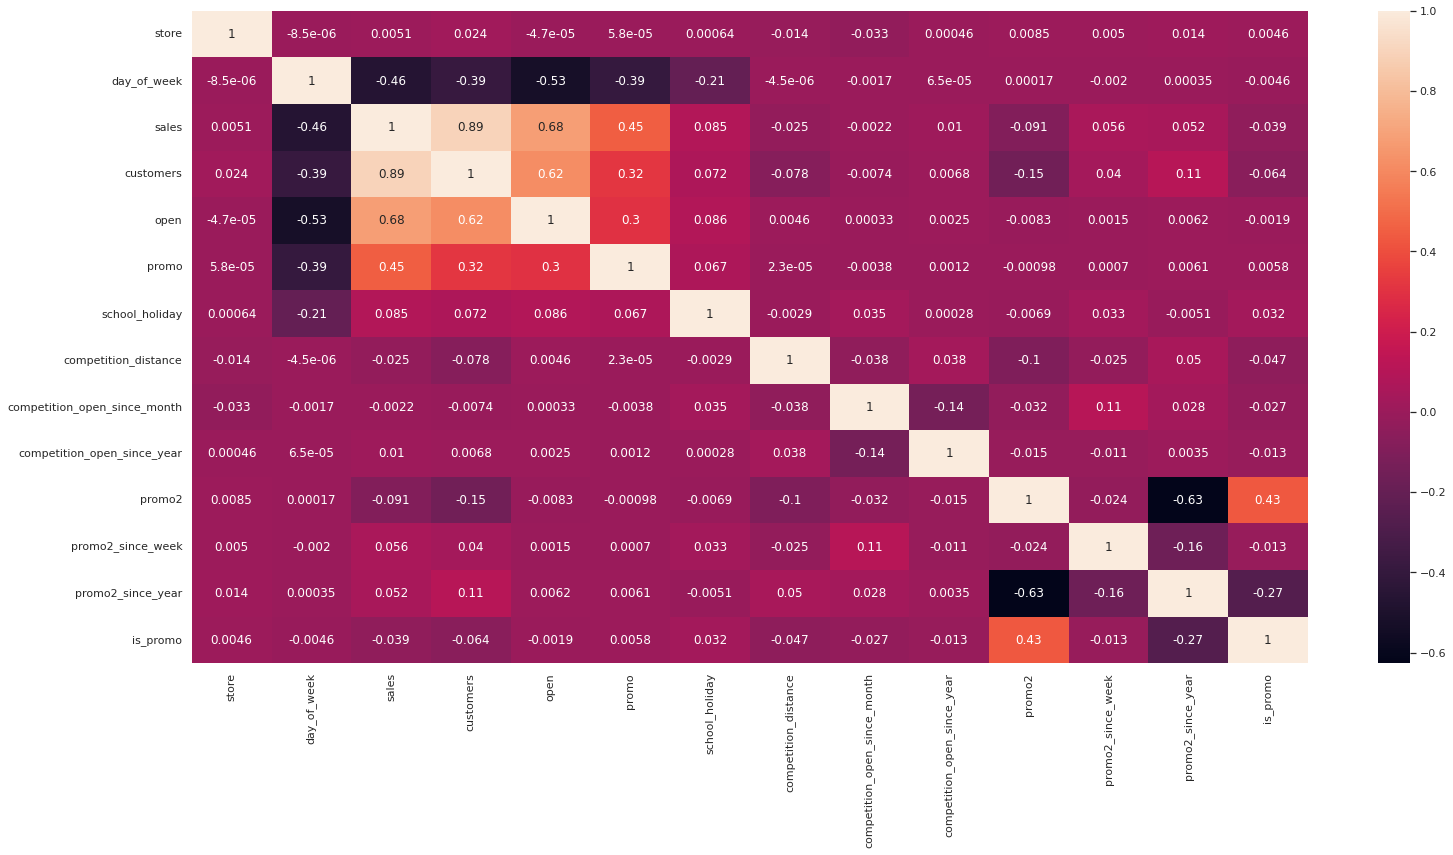

In [ ]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

In [ ]:
a = df4.select_dtypes(include='object')

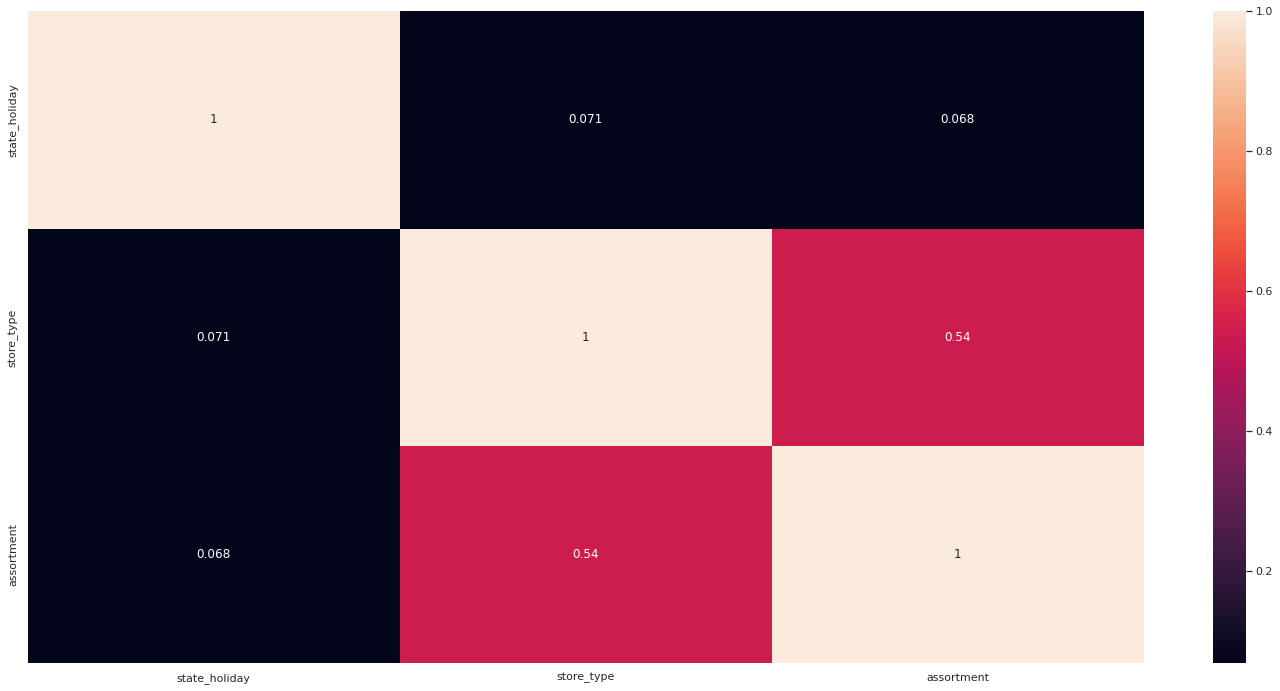

In [ ]:
# ONLY CATEGORICAL data
a = df4.select_dtypes(include='object')

#Calculatre cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#Final DataSet
d = pd.DataFrame({
    'state_holiday': [a1, a2, a3],
    'store_type': [a4, a5, a6],
    'assortment': [a7, a8, a9]
})

d = d.set_index(d.columns)

#Grafic
sns.heatmap(d, annot=True)

# 5.0. DATA PREPARATION

In [ ]:
df5 = df4.copy()

### 5.1  Normalizacao

diminui a variaccao

Nha

## 5.2 Rescaling Features

similar fuzzy

In [ ]:
a = df5.select_dtypes(include=['int64', 'float64'])

/home/arquinho/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='competition_time_month'>

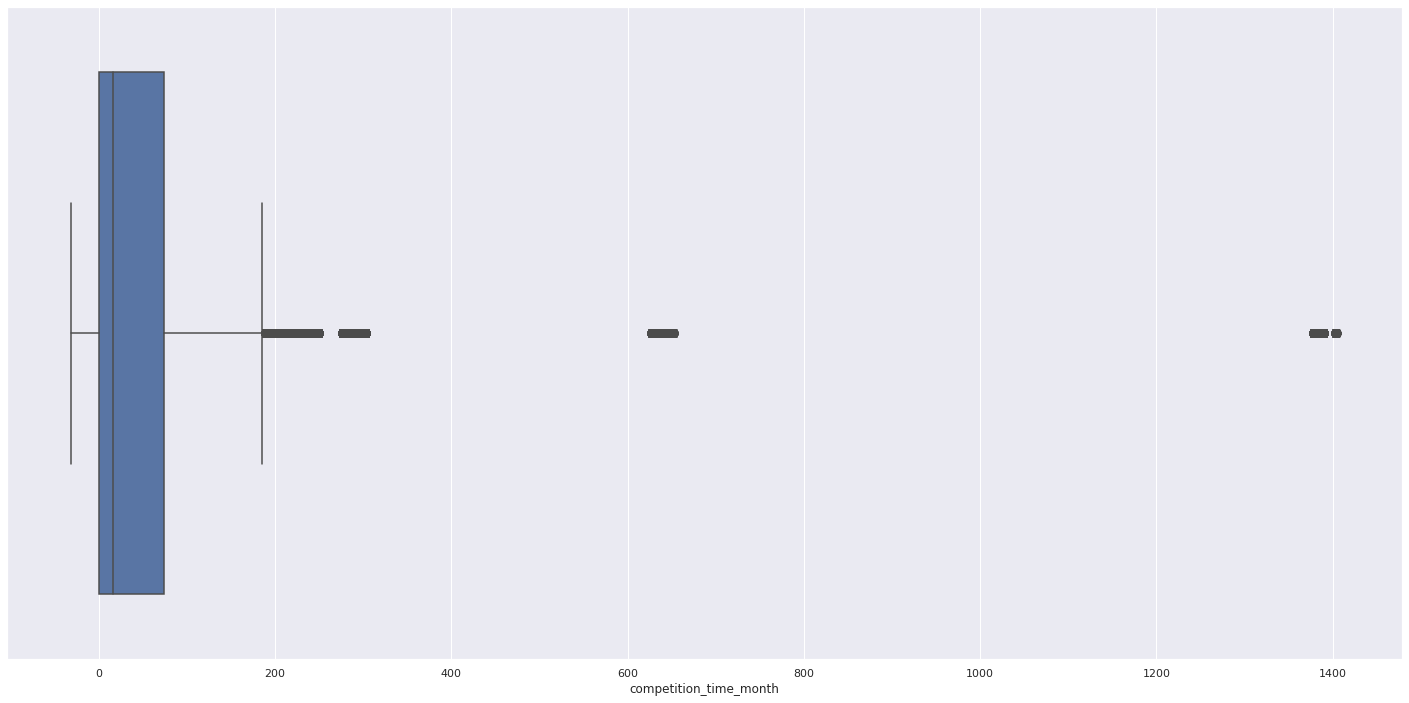

In [ ]:
sns.boxplot(df5['competition_time_month'])

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump( rs, open( '/home/arquinho/REPOS/ds-producao/DsProducao/parameter/competition_distance_scaler.pkl', 'wb' ) )

#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump( rs, open( '/home/arquinho/REPOS/ds-producao/DsProducao/parameter/competition_time_month_scaler.pkl', 'wb' ) )

#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump( mms, open( '/home/arquinho/REPOS/ds-producao/DsProducao/parameter/promo_time_week_scaler.pkl', 'wb' ) )

## 5.3 Transformacao

### 5.3.1 Enconding
transforma caracteres em numeros

In [ ]:
# state_hopliday -- One Hot Encondig
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encondig
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open( '/home/arquinho/REPOS/ds-producao/DsProducao/parameter/store_type_scaler.pkl', 'wb' ) )

# assortment - Ordinal Enconding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Responde Variable Transformation

In [ ]:
df5['sales'] = np.log1p(df5['sales']) #quando a calda de um grafico de uma variavel e´muito longa o log auxilia na reduçao do vies. Confere maior segurança a analise

### 5.3.3 Nature Transformation

In [ ]:
# Separa os periodos do ano em quadrante visando facilitar a comparaçao entre eles
#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2. * np.pi/30)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. * np.pi/12)))

#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2. * np.pi/7)))

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2. * np.pi/52)))


# 6.0. FEATURE SELECTION

In [ ]:
df6 = df5.copy()

## 6.1. SPLIT DATAFRAME INTO TRAINING AND TEST DATASET

In [ ]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_sin,day_cos,month_sin,month_cos,day_of_week_sin,day_of_week_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,0.207912,0.978148,-0.5,-0.866025,-0.974928,-0.222521,-0.568065,-0.822984


In [ ]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [ ]:
df6[['store', 'date']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
5,6,2013-01-02
6,7,2013-01-02
7,8,2013-01-02
8,9,2013-01-02
9,10,2013-01-02


In [ ]:
df6[['store', 'date']].groupby('store').max().reset_index()

df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [ ]:
#definindo quais intervalos sera analisados para sefazer a prediçao. Separando em test e treino e´possivel saber se a qualidade do algotimo esta boa
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. BORUTA AS FEATURE SELECTOR

In [ ]:
# # Training and test dataset for Boruta
# X_train_n = X_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# #define RandomForestRegressor
# rf = RandomForestRegressor (n_jobs=-1) #usa todos os nucleos do processador

# #define Boruta

# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)
#verbose exebi em que aprte da execuçao o boruta esta

In [ ]:
# cols_selected = boruta.support_.tolist()

# #Best Features
# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# #not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))


## 6.3. MANUAL FEATURE SELECTION

In [ ]:
cols_selected_boruta = [
         'store',
         'promo',
         'store_type',
         'assortment',
         'competition_distance',
         'competition_open_since_month',
         'competition_open_since_year',
         'promo2',
         'promo2_since_week',
         'promo2_since_year',
         'competition_time_month',
         'promo_time_week',
         'day_sin',
         'day_cos',
         'month_cos', 
         'month_sin',
         'day_of_week_sin',
         'day_of_week_cos',
         'week_of_year_cos', 
         'week_of_year_sin', 
         'year']
#sugestao do codigo que voce tambem pode incrementar de acordo com sua propria analise
# columnms_to_add
feat_to_add = ['date', 'sales']

#cols final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [ ]:
cols_selected_boruta

# 7.0. MACHINE LEARNING MODELLING

Cross validation: calcula performace real dos m,odelos ao comparar diferentes intervalos de tempo

In [ ]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1. AVERAGE MODEL

In [ ]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#predication
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(
    columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']  #valores reais esperados

#performance
baseline_result = m1_error(
    'Avarege Model', np.expm1(y_test), np.expm1(yhat_baseline)
)  #percisa converter os log para normal com exp antes de exutar
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarege Model,1354.800353,0.455051,1835.135542


## 7.2. LINEAR REGRESSION MODEL

In [ ]:
# model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)
lr_result = m1_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1864.174592,0.286109,2692.723297


### 7.2.1 LINEAR REGRESSION MODEL CROSS VALIDATION

In [ ]:
lr_result_cv = cross_validation(x_training,
                                5,
                                'Linear Regression',
                                lr,
                                verbose=False)
lr_result_cv

,Model Name,MAE cv,MAPE cv,RMSE cv
0,Linear Regression,2040.85+/-268.55,0.3+/-0.01,2914.94+/-398.8


In [ ]:
lr_result_cv

,Model Name,MAE cv,MAPE cv,RMSE cv
0,Linear Regression,2040.85+/-268.55,0.3+/-0.01,2914.94+/-398.8


## 7.3. LINEAR REGRESSION REGULARIZED MODEL

In [ ]:
# model
lrr = Lasso(alpha=0.001).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)
lrr_result = m1_error('Linear Regression - Lasso', np.expm1(y_test),
                      np.expm1(yhat_lrr))
lrr_result

/home/arquinho/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2670.7427785360196, tolerance: 14.554845437738152
  model = cd_fast.enet_coordinate_descent(


,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1869.699838,0.288039,2694.437176


### 7.3.1 LASSO - CROSS VALIDATION#

In [ ]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

/home/arquinho/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1217.6078550759848, tolerance: 11.937395279075501
  model = cd_fast.enet_coordinate_descent(
/home/arquinho/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 229.547188911165, tolerance: 12.565835453461382
  model = cd_fast.enet_coordinate_descent(
/home/arquinho/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1443.4319578017312, tolerance: 13.923171854184755
  model = cd_fast.enet_coordinate_descent(


,Model Name,MAE cv,MAPE cv,RMSE cv
0,Lasso,2088.28+/-325.69,0.3+/-0.01,2987.86+/-497.74


## 7.4. RANDOM FOREST REGRESSOR

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [ ]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1,
                           random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)
rf_result = m1_error('Random Forest Regressor', np.expm1(y_test),
                     np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.0614,0.100103,1010.544647


### 7.4.1 RANDOM FOREST REGRESSOR - CROSS VALIDATION

In [ ]:
rf_result_cv = cross_validation(x_training,
                                5,
                                'Random Forest Regressor',
                                rf,
                                verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE cv,MAPE cv,RMSE cv
0,Random Forest Regressor,836.79+/-217.74,0.12+/-0.02,1255.14+/-317.71


### 7.5. XGBOST REGRESSOR 

In [ ]:
#model
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,  #tamanho
    eta=0.1,
    max_depth=20,  #subnos
    subsample=0.7,
    colsample_bytree=0.9).fit(x_train, y_train)

#model_xgb = xgb.XGBRegressor().fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)
# perfomance
xgb_result = m1_error('XGBoost Regressor', np.expm1(y_test),
                      np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,749.688014,0.108291,1084.610332


## 7.5.1 XGBOOST REGRESSOR  - CROSS VALIDATION

In [ ]:
xgb_result_cv = cross_validation(x_training,
                                 5,
                                 'XGBOOST REGRESSOR',
                                 model_xgb,
                                 verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE cv,MAPE cv,RMSE cv
0,XGBOOST REGRESSOR,857.61+/-178.02,0.12+/-0.02,1244.11+/-253.32


## 7.6. COMPARE MODEL'S PERFOMANCE

### 7.6.1 SINGLE PERFORMANCE

In [ ]:
modelling_result = pd.concat(
    [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,680.061400,0.100103,1010.544647
0,XGBoost Regressor,749.688014,0.108291,1084.610332
0,Avarege Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1864.174592,0.286109,2692.723297
0,Linear Regression - Lasso,1869.699838,0.288039,2694.437176


### 7.6.2 REAL PERFOMANCE - CROSS VALIDATION

In [ ]:
modelling_result_cv = pd.concat(
    [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE cv')

,Model Name,MAE cv,MAPE cv,RMSE cv
0,XGBOOST REGRESSOR,857.61+/-178.02,0.12+/-0.02,1244.11+/-253.32
0,Random Forest Regressor,836.79+/-217.74,0.12+/-0.02,1255.14+/-317.71
0,Linear Regression,2040.85+/-268.55,0.3+/-0.01,2914.94+/-398.8
0,Lasso,2088.28+/-325.69,0.3+/-0.01,2987.86+/-497.74


# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. RANDOM PARAMETERS SELECTION

In [ ]:
# warnings.filterwarnings('ignore')
# param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
#          'eta': [0.1, 0.2, 0.3],
#          'max_depth': [3, 6, 9],
#          'subsample': [0.1, 0.5, 0.7, 0.9],
#          'colsample_bytree': [0.3, 0.7, 0.9],
#          'min_child_weight': [3, 9, 12, 15]
#         }

# MAX_EVAL = 10

In [ ]:
# final_result = pd.DataFrame()
# for i in range (MAX_EVAL):
#     #choose values for parameters randomly
#     hp = {k: random.sample(v,1)[0] for k, v in param.items()}
#     print( hp )
#     #model 
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'])


#     #prediction
#     result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#     final_result = pd.concat([final_result, result])

# final_result

## 8.2. FINAL MODEL

In [ ]:

param_tuned = {
         'n_estimators': 2500,
         'eta': 0.1,
         'max_depth': 6,
         'subsample': 0.9,
         'colsample_bytree': 0.9,
         'min_child_weight': 15
        }


In [ ]:
#model
model_xgb_tuned = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=param_tuned['n_estimators'],
    eta=param_tuned['eta'],
    max_depth=param_tuned['max_depth'],
    subsample=param_tuned['subsample'],
    colsample_bytree=param_tuned['colsample_bytree'],
    min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = m1_error('XGBoost Regressor', np.expm1(y_test),
                            np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,655.201705,0.096633,940.832387


# 9.0. INTERPRETATION AND TRANSLATE OF ERROR 

In [ ]:
df9 = X_test[ cols_selected_boruta_full ]

#rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

/tmp/ipykernel_33100/3584423800.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'] )
/tmp/ipykernel_33100/3584423800.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xgb_tuned )


## 9.1. BUSINESS PERFORMANCE

In [ ]:
#SUM OF PREDICTIONS
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE 
# calcula o erro. diferenca do valor real e do predito. Y-Yhat
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( 
                lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )

#MAPE
# Similar ao MAE entretanto entrega qual a porcentagem de diferenca. N util caso seja necessario prever valores = 0
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( 
                lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

#merge 
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

#scenarios
df92['best_scenario'] = df92['predictions'] +  df92['MAE']
df92['worst_scenario'] = df92['predictions'] - df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'best_scenario', 'worst_scenario', 'MAE', 'MAPE']]

In [ ]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,best_scenario,worst_scenario,MAE,MAPE
291,292,107471.218750,110823.273065,104119.164435,3352.054315,0.573093
908,909,231564.234375,239329.386061,223799.082689,7765.151686,0.518958
721,722,367376.625000,369757.182261,364996.067739,2380.557261,0.321944
875,876,201894.703125,205810.674391,197978.731859,3915.971266,0.290594
273,274,196791.125000,198112.194580,195470.055420,1321.069580,0.230052


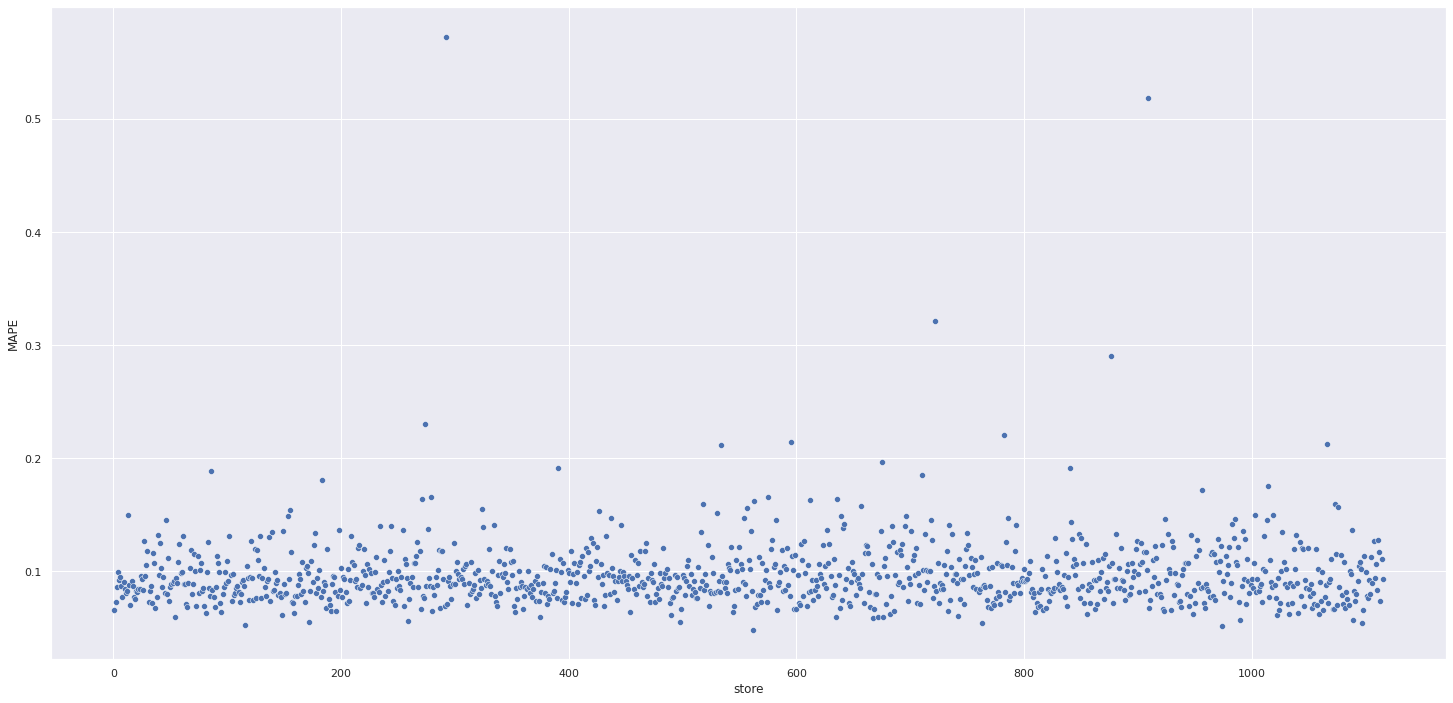

In [ ]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2. TOTAL PERFOMANCE

In [ ]:
df93 = df92[['predictions', 'best_scenario',
             'worst_scenario']].apply(lambda x: np.sum(x),
                                      axis=0).reset_index().rename(columns={
                                          'index': 'Scenario',
                                          0: 'Values'
                                      })
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93.head()

,Scenario,Values
0,predictions,"R$286,628,352.00"
1,best_scenario,"R$287,363,258.16"
2,worst_scenario,"R$285,893,481.51"


## 9.3. MACHINE LEARNING PERFORMANCE

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

/tmp/ipykernel_33100/1385645114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
/tmp/ipykernel_33100/1385645114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


/home/arquinho/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


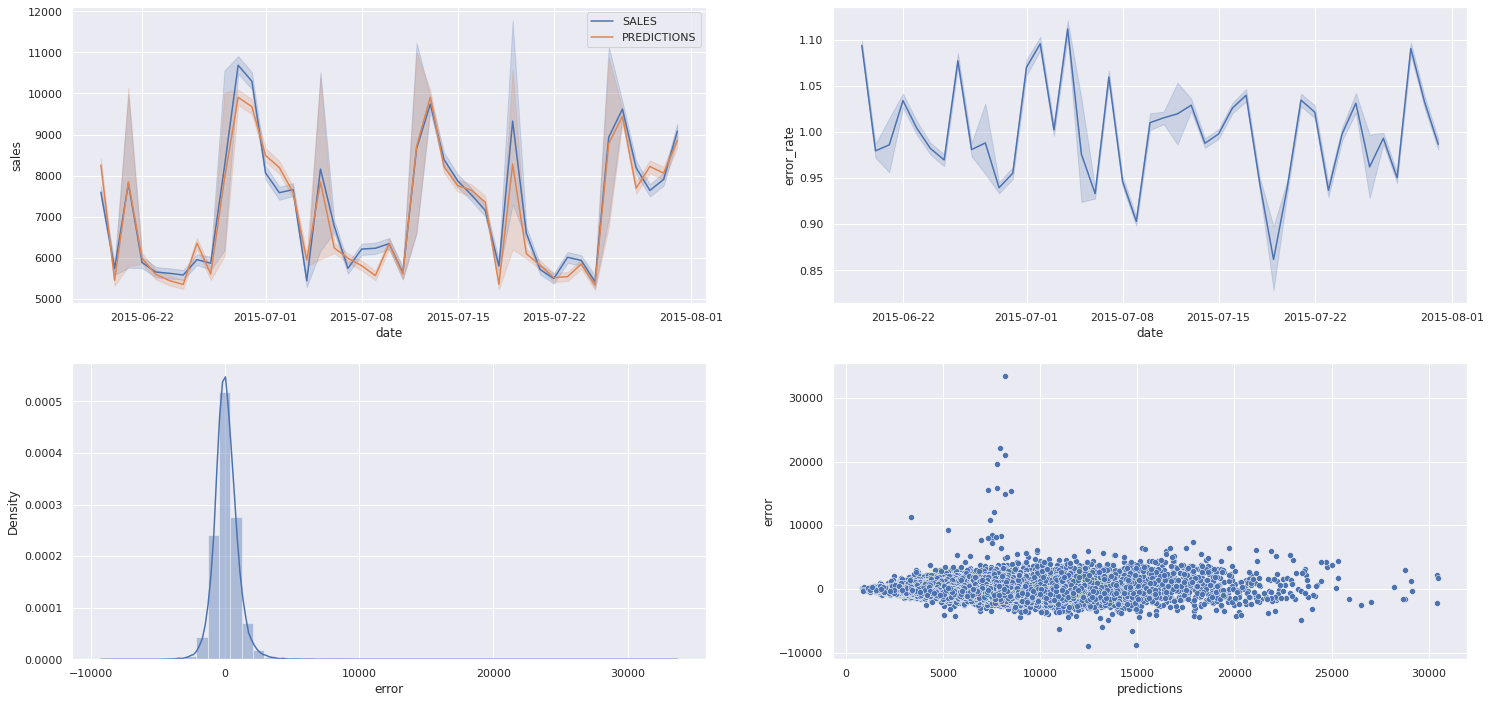

In [ ]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(x=df9['predictions'], y=df9['error'])

# 10.0. DEPLOY MODEL TO PRODUCTION

In [ ]:
#save trained model
pickle.dump( model_xgb_tuned, open( '/home/arquinho/REPOS/ds-producao/DsProducao/model/model_rossmann.pkl', 'wb' ) )

## 10.1. ROSSMANN CLASS

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self_competition_distance_scaller = pickle.load( open( '/home/arquinho/REPOS/ds-producao/DsProducao/parameter/competition_distance_scaller.pkl', 'rb' ) )
        self_competition_time_month_scaller = pickle.load( open( '/home/arquinho/REPOS/ds-producao/DsProducao/parameter/competition_time_month_scaller.pkl', 'rb' ) )
        self_promo_time_week_scaller = pickle.load( open( '/home/arquinho/REPOS/ds-producao/DsProducao/parameter/promo_time_week_scaller.pkl', 'rb' ) )
        self_store_type_scaller = pickle.load( open( '/home/arquinho/REPOS/ds-producao/DsProducao/parameter/store_type_scaller.pkl', 'rb' ) )

       

    def data_cleaning( self, df1 ):

        #1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore( x )
        
        cols_new = list( map( snakecase, cols_old ) )
        

        # rename
        df1.columns = cols_new



        #1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )



        #1.5. Fillout NA

        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )
        
        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
        
        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
        
        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
        
        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )
        
        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}
        
        df1['promo_interval'].fillna(0, inplace=True )
        
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )
        


        #1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        

        
        return df1
    
    
    def feature_engineering( self, df2 ):
        
        #2.4. Feature Engineering

        # year
        df2['year'] = df2['date'].dt.year
        
        # month
        df2['month'] = df2['date'].dt.month
        
        # day
        df2['day'] = df2['date'].dt.day
        
        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week 
        
        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
        
        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )
        
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )
        
        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
        
        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        #3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        #3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2
    
    def data_preparation( self, df5 ):
        
        #competition distance
        df5['competition_distance'] = self_competition_distance_scaller.fit_transform(df5[['competition_distance']].values)
        
        #competition time month
        df5['competition_time_month'] = self_competition_time_month_scaller.fit_transform(df5[['competition_time_month']].values)
        
        #promo time week
        df5['promo_time_week'] = self_promo_time_week_scaller.fit_transform(df5[['promo_time_week']].values)


        #5.3 Transformacao

        #5.3.1 Enconding
        # state_hopliday -- One Hot Encondig
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])
        
        # store_type - Label Encondig
        df5['store_type'] = self_store_type_scaller.fit_transform(df5['store_type'])

        # assortment - Ordinal Enconding
        assortment_dict = {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
      
        #5.3.3 Nature Transformation

        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2. * np.pi/30)))
        
        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2. * np.pi/12)))
        
        #day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2. * np.pi/7)))
        
        #week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2. * np.pi/52)))
        
        cols_selected_boruta = ['store', 'promo','store_type','assortment','competition_distance','competition_open_since_month', 
                                'competition_open_since_year', 'promo2','promo2_since_week','promo2_since_year',
                                'competition_time_month', 'promo_time_week', 'day_sin', 'day_cos','month_cos', 'month_sin',
                                'day_of_week_sin', 'day_of_week_cos','week_of_year_cos', 'week_of_year_sin', 'year']
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data):
        #prediction
        pred = model.predict( test_data )
        
        #join pred into the original data
        original_data['predictions'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

##  API HANDLER

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loadinf model
model = pickle.load( open( '/home/arquinho/REPOS/ds-producao/DsProducao/model/model_rossmann.pkl', 'rb' ) )

#Iniatialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST']) #app.route permite visualizar em Flask a funçao
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        if isinstance( test_json, dict  ): #uniwue example, retorna true ou false isisntance
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple examples
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        #Instatntiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        #data preparation
        df3 = pipeline.data_preparation( df2 )
        
        #prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    
    
    else:
        return Response( '{}', status=200, mimetype='application/json')

    
if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'rossmann'

## API TESTER

In [ ]:
# loading test dataset
df10 = pd.read_csv( '/home/arquinho/REPOS/ds-producao/DsProducao/data/test.csv' )
df11 = df_store_raw = pd.read_csv( '/home/arquinho/REPOS/ds-producao/DsProducao/data/store.csv', low_memory=False )
#df11 = pd.read_csv( '/home/arquinho/REPOS/ds-producao/DsProducao/stores_int.csv', low_memory=False )

df11.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [ ]:
# merge test dataset + stored
df_test = pd.merge( df10, df11, how='left', on='Store')


# # FLOAT TO INT
# # CompetitionDistance
# df_test = df_test[~df_test['CompetitionDistance'].isnull()]
# df_test['CompetitionDistance'] = df_test['CompetitionDistance'].astype(int64)

# # CompetitionOpenSinceMonth
# df_test = df_test[~df_test['CompetitionOpenSinceMonth'].isnull()]
# df_test['CompetitionOpenSinceMonth'] = df_test['CompetitionOpenSinceMonth'].astype(int64)

# # CompetitionOpenSinceYear
# df_test = df_test[~df_test['CompetitionOpenSinceYear'].isnull()]
# df_test['CompetitionOpenSinceYear'] = df_test['CompetitionOpenSinceYear'].astype(int64)

# # Promo2SinceWeek
# df_test = df_test[~df_test['Promo2SinceWeek'].isnull()]
# df_test['Promo2SinceWeek'] = df_test['Promo2SinceWeek'].astype(int64)

# # Promo2SinceYear
# df_test = df_test[~df_test['Promo2SinceYear'].isnull()]
# df_test['Promo2SinceYear'] = df_test['Promo2SinceYear'].astype(int64)

# # Promo2
# df_test = df_test[~df_test['Promo2'].isnull()]
# df_test['Promo2'] = df_test['Promo2'].astype(int64)


# chose store for rpediction
df_test = df_test[df_test['Store'].isin([32, 43, 90]) ]

# remoive closed days
df_test = df_test[df_test['Open'] != 0 ]
df_test = df_test[~df_test['Open'].isnull()]

df_test = df_test.drop( 'Id', axis=1 )
#df_test.to_csv('stores_int.csv')

In [ ]:
# df12 = pd.read_csv( '/home/arquinho/REPOS/ds-producao/DsProducao/stores_int.csv', low_memory=False )
# df12 = df12.drop( 'Unnamed: 0', axis=1 )

# df12.head()

In [ ]:
data = json.dumps( df_test.to_dict( orient='records' ) ) #converte em string JSON

In [ ]:
# API call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url= ' https://rossmann--sales--prediction.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code{}'. format( r.status_code ) )

Status Code200


In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [ ]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,32,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,2910.0,9,2015,1,45,2009,"Feb,May,Aug,Nov",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2009-11-02T00:00:00.000Z,306,3642.012695
1,43,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,d,basic,4880.0,9,2015,1,37,2009,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2009-09-07T00:00:00.000Z,314,5320.505859
2,90,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,330.0,11,2007,0,38,2015,0,Sep,0,2015,9,17,38,2015-37,2007-11-01T00:00:00.000Z,95,2015-09-14T00:00:00.000Z,0,5180.371094
3,32,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,basic,2910.0,9,2015,1,45,2009,"Feb,May,Aug,Nov",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2009-11-02T00:00:00.000Z,306,4029.575195
4,43,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,d,basic,4880.0,9,2015,1,37,2009,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2009-09-07T00:00:00.000Z,314,6053.690918


In [ ]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
    d2.loc[i, 'store'],
    d2.loc[i, 'prediction'] ) )

Store Number 32 will sell R$134,256.82 in the next 6 weeks
Store Number 43 will sell R$222,886.85 in the next 6 weeks
Store Number 90 will sell R$210,320.69 in the next 6 weeks


In [ ]:
r.json

In [ ]:
df_test

In [ ]:
df_test = pd.read_csv( '/home/arquinho/REPOS/ds-producao/DsProducao/data/store.csv', low_memory=False )

# FLOAT TO INT
# CompetitionDistance
df_test = df_test[~df_test['CompetitionDistance'].isnull()]
df_test['CompetitionDistance'] = df_test['CompetitionDistance'].astype(int64)

# CompetitionOpenSinceMonth
df_test = df_test[~df_test['CompetitionOpenSinceMonth'].isnull()]
df_test['CompetitionOpenSinceMonth'] = df_test['CompetitionOpenSinceMonth'].astype(int64)

# CompetitionOpenSinceYear
df_test = df_test[~df_test['CompetitionOpenSinceYear'].isnull()]
df_test['CompetitionOpenSinceYear'] = df_test['CompetitionOpenSinceYear'].astype(int64)

# Promo2SinceWeek
df_test = df_test[~df_test['Promo2SinceWeek'].isnull()]
df_test['Promo2SinceWeek'] = df_test['Promo2SinceWeek'].astype(int64)

# Promo2SinceYear
df_test = df_test[~df_test['Promo2SinceYear'].isnull()]
df_test['Promo2SinceYear'] = df_test['Promo2SinceYear'].astype(int64)

# Promo2
df_test = df_test[~df_test['Promo2'].isnull()]
df_test['Promo2'] = df_test['Promo2'].astype(int64)

In [ ]:
df_test.to_csv('stores_int.csv')

In [ ]:
# loading test dataset
df10 = pd.read_csv( '/home/arquinho/REPOS/ds-producao/DsProducao/data/test.csv' )

In [ ]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [ ]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
#url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )